# Explore harvested text files

In [1]:
import os
import pandas as pd
import fileinput
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textblob import TextBlob
from operator import itemgetter
from pathlib import Path
import nltk
import numpy as np
import altair as alt

# Are you using Jupyter Lab?
# If so either don't run this cell or comment out the line below

# alt.renderers.enable('notebook')

# If you forget, run this cell, and then get strange warnings when you make a chart,
# uncomment the following line and run this cell to reset the chart renderer

# alt.renderers.enable('default')

# alt.data_transformers.enable('json')
#nltk.download('stopwords')
#nltk.download('punkt')
#stopwords = nltk.corpus.stopwords.words('english')

In [2]:
# Import a harvest zip file you've created previously
# First upload the zip file to the data directory, then run this cell
import zipfile
for zipped in sorted(Path('data').glob('*.zip')):
    print(f'Unzipping {zipped}...')
    with zipfile.ZipFile(zipped, 'r') as zip_file:
        zip_file.extractall(Path(f'data/{zipped.stem}'))

Unzipping data/1561782184.zip...
Unzipping data/1565575636.zip...


In [2]:
def get_latest_harvest():
    '''
    Get the timestamp of the most recent harvest.
    '''
    harvests = sorted([d for d in Path('data').iterdir() if d.is_dir() and not d.name.startswith('.')])
    try:
        harvest = harvests[-1]
    except IndexError:
        print('No harvests!')
        harvest = None
    return harvest

In [3]:
def get_docs(harvest):
    docs_path = get_docs_path(harvest)
    for p in docs_path:
        yield p.read_text(encoding='utf-8').strip()
        
def get_docs_path(harvest):
    path = Path(f'{harvest}/text')
    docs_path = [p for p in sorted(path.glob('*.txt'))]
    return docs_path

def get_file_names(harvest):
    return [p.stem for p in get_docs_path(harvest)]

In [4]:
harvest = get_latest_harvest()

In [5]:
vectorizer = CountVectorizer(stop_words='english', max_features=10000, ngram_range=(1,1))
# preprocessor = lambda x: re.sub(r'(\d[\d\.])+', 'NUM', x.lower())
X_freq = np.asarray(vectorizer.fit_transform(get_docs(harvest)).todense())
df_freq = pd.DataFrame(X_freq, columns=vectorizer.get_feature_names(), index=get_file_names(harvest))

In [6]:
df_freq.sum().nlargest(20)

mr            18034
tho           16051
south          9526
weather        6944
new            6338
day            5458
rain           5066
north          4990
wragge         4715
time           4673
australia      4340
great          4283
tbe            4105
queensland     3793
years          3727
brisbane       3550
west           3525
good           3391
ing            3220
man            3116
dtype: int64

In [7]:
# The number of words you want to show
num_words = 20
top_words = pd.DataFrame({n: df_freq.T[col].nlargest(num_words).index.tolist() for n, col in enumerate(df_freq.T)}).T
top_words.index = get_file_names(harvest)
top_words.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
18601224-13-5696044,cases,case,casks,packages,tons,bags,brothers,22,bundles,bales,hardware,10,20,30,ship,boxes,barrels,kegs,dec,mrs
18620111-319-196391314,tons,agents,mr,passengers,mrs,agent,ult,ship,brig,captain,miss,newcastle,barque,january,new,otago,messrs,rev,white,ballast
18630905-319-197290261,tons,agents,passengers,mrs,mr,ship,cabin,miss,agent,ballast,steerage,messrs,schooner,white,barque,captain,june,september,brig,brothers
18640220-319-197293051,mr,tho,time,meeting,melbourne,bo,present,sir,having,act,appears,court,despatch,gallons,hughes,000,annum,majesty,received,county
18641115-809-155019508,tho,mr,aud,ho,defendant,having,case,committee,court,meeting,held,plaintiff,yesterday,bo,day,following,half,man,named,present


## Add a 'year' column to the dataframe

Each file name includes the date on which the article was published. For example, `18601224-13-5696044` was published on 24 December 1860. We can easily extract the year by just slicing the first four characters off the file name.

In [8]:
years = [int(p[:4]) for p in get_file_names(harvest)]
df_freq_years = df_freq.assign(year=years)

## Most frequent words each year

In [9]:
# Top words per year
year_groups = df_freq_years.groupby(by='year')
year_group_totals = year_groups.sum()
df_years = pd.DataFrame({n: year_group_totals.T[col].nlargest(10).index.tolist() for n, col in enumerate(year_group_totals.T)}).T
df_years.index = [name for name, _ in year_groups]
df_years.head()

,0,1,2,3,4,5,6,7,8,9
1860,cases,case,casks,packages,tons,bags,brothers,22,bundles,bales
1862,tons,agents,mr,passengers,mrs,agent,ult,ship,brig,captain
1863,tons,agents,passengers,mrs,mr,ship,cabin,miss,agent,ballast
1864,tho,mr,new,melbourne,000,total,having,south,time,great
1867,mr,duke,john,said,ing,smith,thomas,lord,melbourne,street


## Visualise top ten words per year

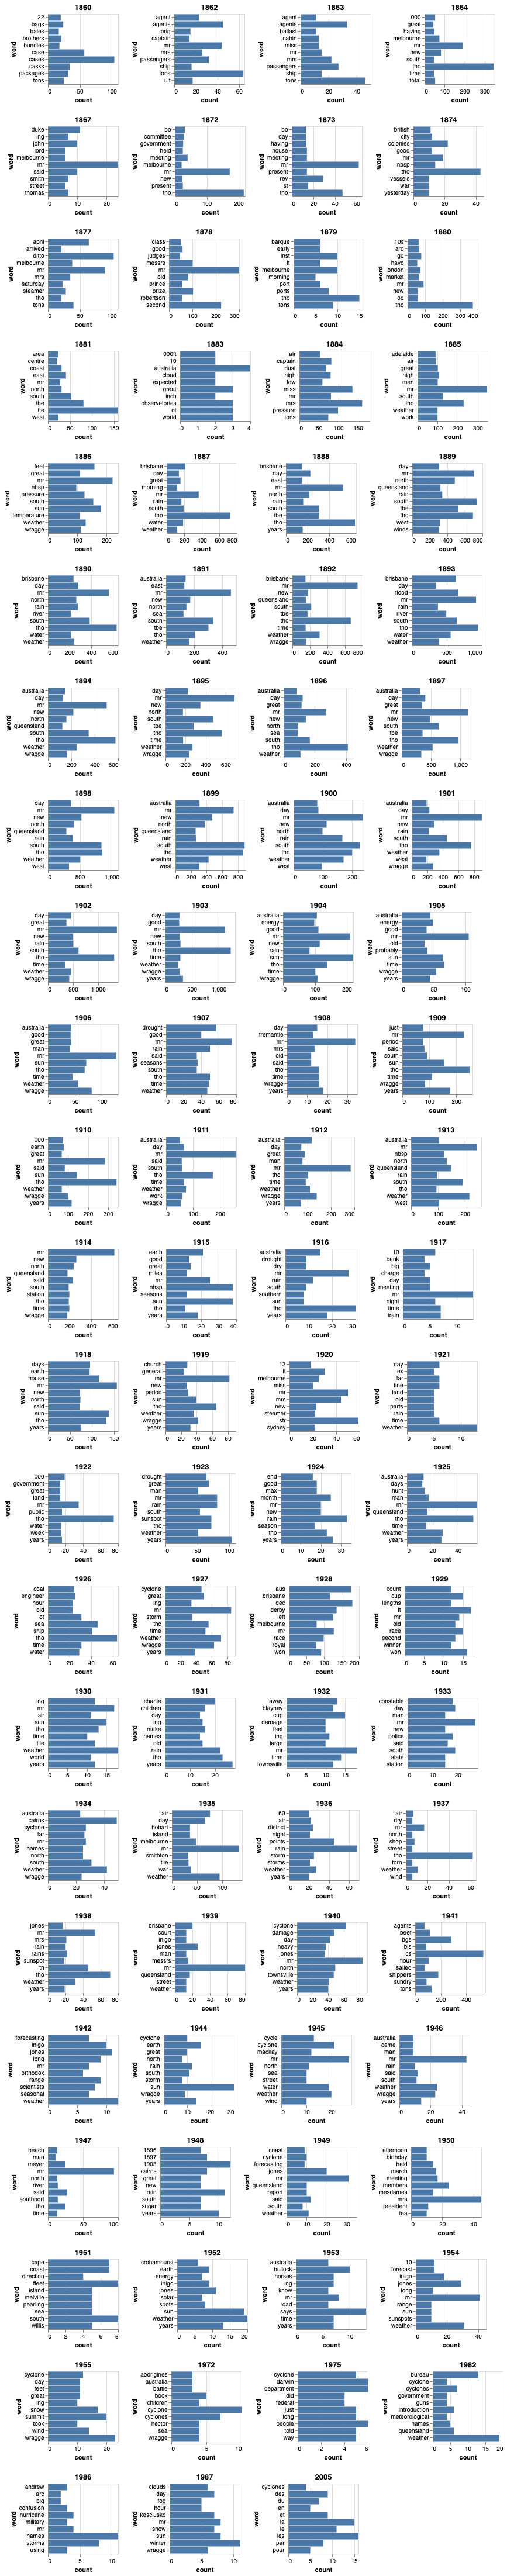

In [41]:
compound_chart = alt.vconcat()
years = df_years.index.tolist()
# Number of columns
cols = 4
start = 0
while start < len(years):
    row = alt.hconcat()
    for year in years[start:start+cols]:
        df_year_word_count = pd.DataFrame([{'word': w, 'count': year_group_totals.loc[year][w]} for w in df_years.loc[year].tolist()])
        chart = alt.Chart(df_year_word_count).mark_bar().encode(
            y='word:N',
            x='count:Q',
        ).properties(width=120, height=120, title=str(year), columns=4)
        row |= chart
    compound_chart &= row
    start += cols
compound_chart

## Visualise word frequencies over time

In [16]:
def words_by_year(df, words):
    df_words = pd.DataFrame()
    for word in words:
        try:
            df_word = df.groupby(by='year').sum()[word].to_frame().reset_index().rename({word: 'count'}, axis=1)
        except KeyError:
            print(f"'{word}' not found")
        else:
            df_word['word'] = word
            df_words = df_words.append(df_word, ignore_index=True)
    return df_words

In [17]:
df_words = words_by_year(df_freq_years, ['racism', 'racial', 'white race', 'chinese', 'kangaroo'])

'racism' not found
'racial' not found
'white race' not found


### Create a faceted chart

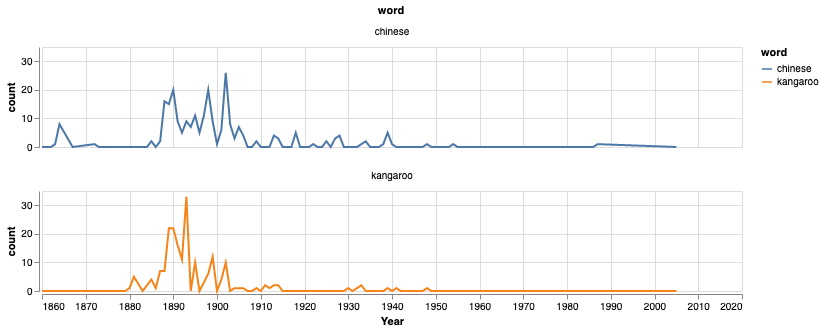

In [18]:
alt.Chart(df_words.loc[df_words['year'] > 0]).mark_line().encode(
    x=alt.X('year:Q', axis=alt.Axis(format='c', title='Year')),
    y='count:Q',
    color='word:N',
    facet='word:N'
).properties(width=700, height=100, columns=1)

### Create a bubbleline chart

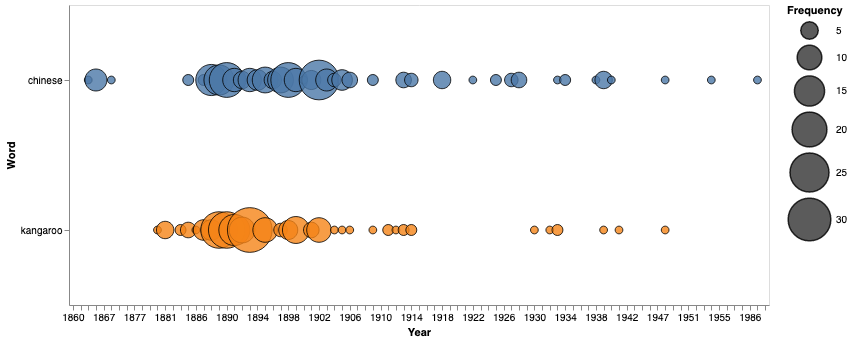

In [19]:
# Create a chart
alt.Chart(df_words.loc[df_words['year'] > 0]).mark_circle(
    
    # Style the circles
    opacity=0.8,
    stroke='black',
    strokeWidth=1
).encode(
    
    # Year on the X axis
    x=alt.X('year:O', axis=alt.Axis(format='c', title='Year', labelAngle=0)),
    
    # Object type on the Y axis
    y=alt.Y('word:N', title='Word'),
    
    # Size of the circles represents the number of objects
    size=alt.Size('count:Q',
        scale=alt.Scale(range=[0, 2000]),
        legend=alt.Legend(title='Frequency')
    ),
    
    # Color the circles by object type
    color=alt.Color('word:N', legend=None),
    
    # More details on hover
    tooltip=[alt.Tooltip('word:N', title='Word'), alt.Tooltip('year:O', title='Year'), alt.Tooltip('count:Q', title='Frequency', format=',')]
).properties(
    width=700,
    height=300
)

## Visualise word frequences by newspaper

The file titles also include the id of the newspaper they were published in. For example, `18601224-13-5696044` was published in the newspaper with the id of `13`, which happenes to be *The Argus*.